In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import keras
import keras.optimizers as optimizers
from keras import layers, callbacks
from keras import regularizers
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
import pyreadr
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
import random

In [434]:
class DataCreation():
    def __init__(self, sample_size, timestamps):
        self.sample_size = sample_size
        self.timestamps = timestamps
        
    def create_intervals(self, seed):        
        random.seed(seed+100)
        intervals = []
        i = 0
        while i <= self.timestamps:
            length = random.randint(200, 1000)
            if (i + length + 400) > self.timestamps:
                sublist = list((i, self.timestamps))
                intervals.append(sublist)
                break
            else:
                sublist = list((i, i+length-1))
            intervals.append(sublist)
            i = i + length
        return intervals
    
    def create_df(self, seed):
        self.f_x = np.array([])
        
        partitions_1 = self.create_intervals(seed)
        partitions_2 = self.create_intervals(seed+1)
        random.seed(seed)
        for i in range(len(partitions_1)):
            freq = random.choice([6, 8])
            co_ef = random.uniform(8, 10)
            self.f_x = np.append(self.f_x, co_ef * np.sin(np.linspace(0, freq * np.pi, partitions_1[i][1] - partitions_1[i][0] + 1)))

        for i in range(len(partitions_2)):
            mean = 0
            variance = random.uniform(0.1, 2)
            self.f_x[partitions_2[i][0]:partitions_2[i][1]] = self.f_x[partitions_2[i][0]:partitions_2[i][1]] + np.random.normal(mean, variance, partitions_2[i][1] - partitions_2[i][0])
        
        self.f_x = self.f_x[:self.timestamps]
        return self.f_x
    
    def train_test_split(self, split):
        g_x = self.f_x.reshape(self.timestamps // self.sample_size, self.sample_size)
        split = round(len(g_x) * split)
        self.train_X = g_x[:split]
        self.test_X = g_x[split:]
        
    def faulty_data(self, test_data, seed):
        test_data_reshaped = test_data.reshape(test_data.shape[0] * test_data.shape[1])
        random.seed(seed)
        num_anomalies = random.randint(1000, 1500)
        self.normal_timestamps = [i for i in range(len(test_data_reshaped))]
        self.anomaly_timestamps = []
        for i in range(num_anomalies):
            anomaly = random.choice(self.normal_timestamps)
            self.anomaly_timestamps.append(anomaly)
            self.normal_timestamps.remove(anomaly)
        for anomaly in self.anomaly_timestamps:
            if anomaly < 50:
                mean, std = test_data_reshaped[anomaly:anomaly+50].mean(), test_data_reshaped[anomaly:anomaly+50].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
            elif anomaly > len(test_data_reshaped)-50:
                mean, std = test_data_reshaped[anomaly-50:anomaly].mean(), test_data_reshaped[anomaly-50:anomaly].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
            else:
                mean, std = test_data_reshaped[anomaly-25:anomaly+25].mean(), test_data_reshaped[anomaly-25:anomaly+25].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
        return test_data_reshaped
        
    def plot_df(self, sample, size):
        plt.figure(figsize=(12, 6))
        plt.plot(self.f_x)
        plt.xlim([sample*size, sample*size + size])

In [435]:
sample_size, timestamps = 500, 500000

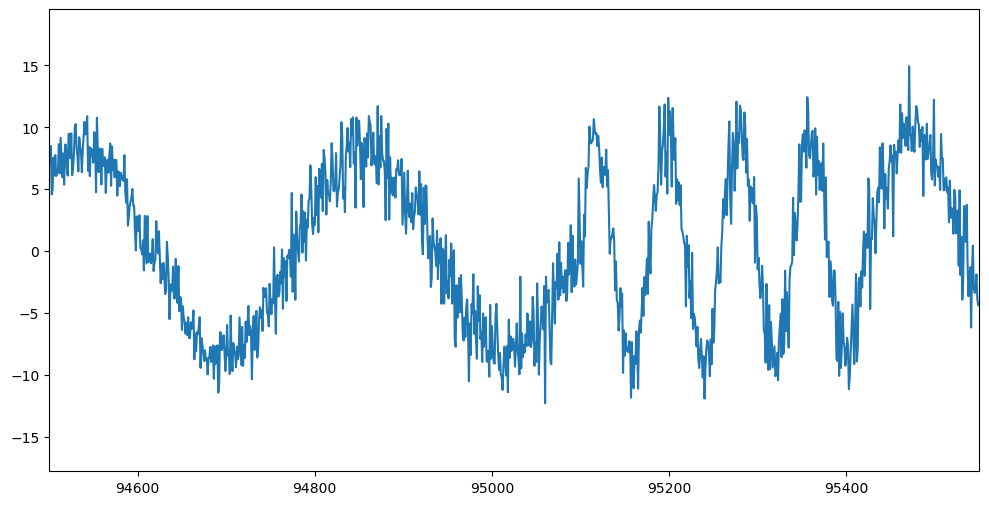

In [436]:
data = DataCreation(sample_size, timestamps)
f_x = data.create_df(200)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X
data.plot_df(90, 1050)

In [437]:
test_X_reshaped = data.faulty_data(test_X, 14000)

Create faulty point anomalies in testing data

In [438]:
# Autoencoder
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.5, patience=50, restore_best_weights=True)

model = keras.Sequential([
    layers.Dense(256, input_shape=(sample_size,), activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(sample_size)
])
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
history = model.fit(train_X, train_X, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping], verbose=0)

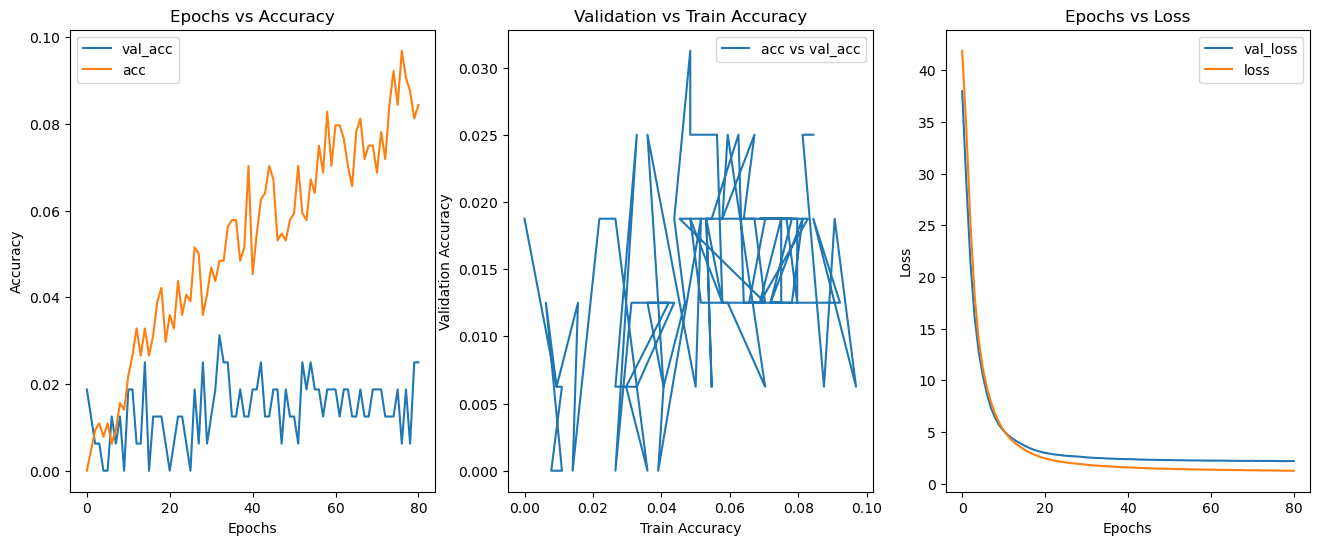

In [439]:
plt.figure(figsize=(16, 6))
h = history.history
plt.subplot(131)
plt.plot(range(len(h['val_accuracy'])), h['val_accuracy'], label='val_acc')
plt.plot(range(len(h['accuracy'])), h['accuracy'], label='acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title(f"Epochs vs Accuracy")

plt.subplot(132)
plt.plot(h['accuracy'], h['val_accuracy'], label='acc vs val_acc')
plt.xlabel("Train Accuracy")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title(f"Validation vs Train Accuracy")
        
plt.subplot(133)
plt.plot(range(len(h['val_loss'])), h['val_loss'], label='val_loss')
plt.plot(range(len(h['loss'])), h['loss'], label='loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Epochs vs Loss")
plt.show()

#### Static threshold 

In [440]:
test_X_rec = model.predict(test_X)
test_X_rec = test_X_rec.reshape(test_X_rec.shape[0] * test_X_rec.shape[1])
p, r, f1 = [], [], []
for i in range(200):
    times = set([i for i in range(len(test_X_rec))])
    threshold = 2 + 0.1 * i
    anomalies = np.where(np.abs(test_X_reshaped - test_X_rec) > threshold)
    tp = np.sum(np.isin(anomaly_timestamps, anomalies[0]))
    fp = np.sum(np.isin(normal_timestamps, anomalies[0]))
    tn = np.sum(np.isin(np.array(list(times - set(anomalies[0]))), anomalies[0]))
    fn = np.sum(np.isin(np.array(list(times - set(anomalies[0]))), anomaly_timestamps))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    p.append(precision)
    r.append(recall)
    f1.append(2 * ((precision * recall) / (precision + recall)))

7/7 [==============================] - 0s 2ms/step


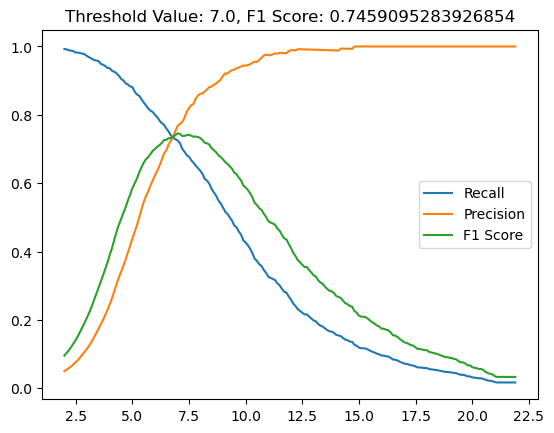

In [441]:
plt.title(f"Threshold Value: {2 + 0.1 * f1.index(max(f1))}, F1 Score: {max(f1)}")
x = [2 + 0.1 * i for i in range(len(r))]
plt.plot(x, r, label="Recall")
plt.plot(x, p, label="Precision")
plt.plot(x, f1, label="F1 Score")
plt.legend()
plt.show()

In [442]:
threshold = 7
anomalies = np.where(np.abs(test_X_reshaped - test_X_rec) > threshold)
print(f"Threshold Value: {threshold}")
print(f"Accuractely Detected Anomalies out of {len(anomaly_timestamps)}: {np.sum(np.isin(anomaly_timestamps, anomalies[0]))}")
print(f"False Alarms out of {len(normal_timestamps)}: {np.sum(np.isin(normal_timestamps, anomalies[0]))}")

Threshold Value: 7
Accuractely Detected Anomalies out of 1069: 775
False Alarms out of 98931: 234


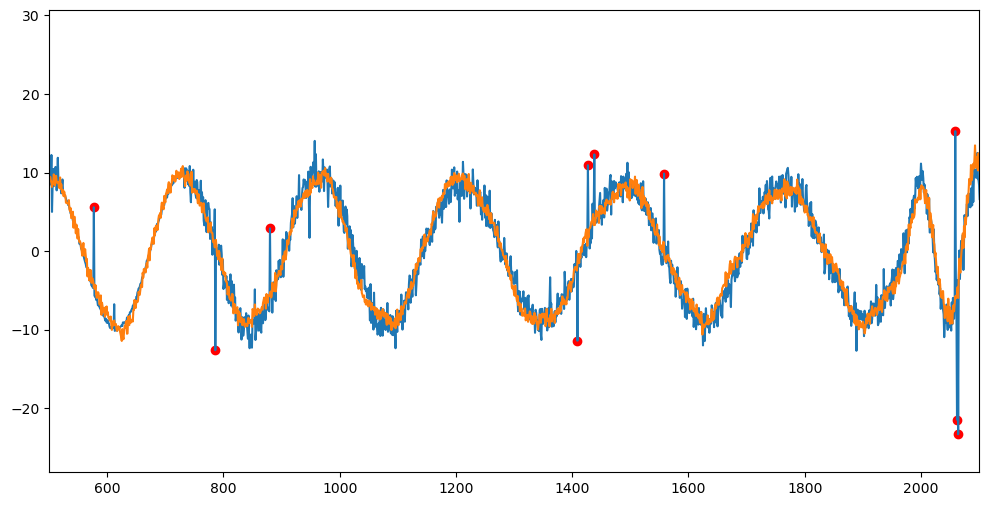

In [445]:
threshold = 7
anomalies = np.where(np.abs(test_X_reshaped - test_X_rec) > threshold)

i = 1
plt.figure(figsize=(12, 6))
plt.plot(test_X_reshaped)
plt.plot(test_X_rec)
plt.scatter(anomalies, test_X_reshaped[anomalies], color='red')
plt.xlim([i*500, i*500 + 1600])
plt.show()

In [484]:
sample_error = np.array([])
for i in range(len(train_X)):
    sample_error = np.append(sample_error, mae(train_X[i], train_X_rec[i]))
print(sample_error.max())
print(np.where(sample_error == sample_error.max()))
temp_df = pd.DataFrame({'values': sample_error})
#temp_df.describe()
len(np.where(sample_error > 1)[0])

3.7683009279498054
(array([938], dtype=int64),)


120

7/7 [==============================] - 0s 2ms/step


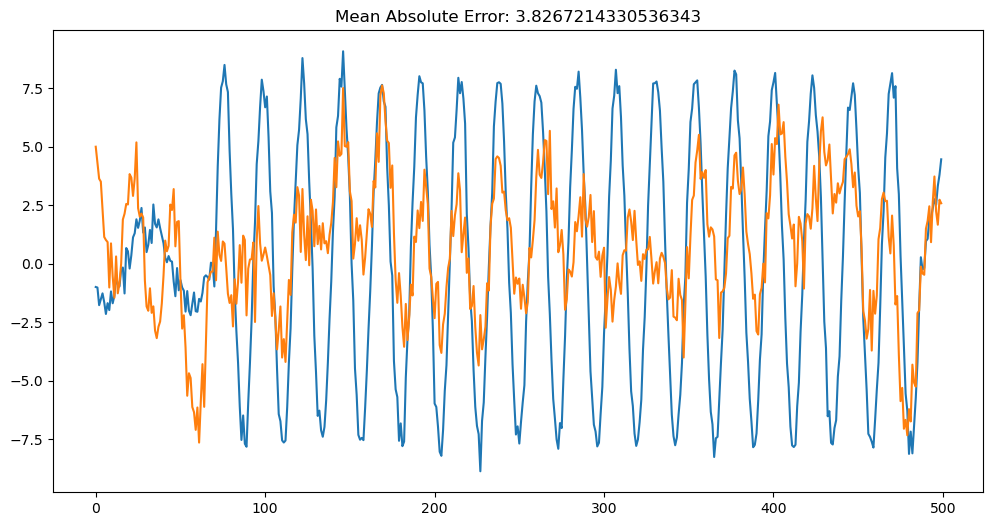

In [273]:
test_X_rec = model.predict(test_X)
sample = 140
plt.figure(figsize=(12, 6))
plt.title(f"Mean Absolute Error: {mae(test_X[sample], test_X_rec[sample])}")
plt.plot(test_X[sample])
plt.plot(test_X_rec[sample])
plt.show()

In [272]:
sample_error = np.array([])
for i in range(len(test_X)):
    sample_error = np.append(sample_error, mae(test_X[i], test_X_rec[i]))
print(sample_error.max())
np.where(sample_error == sample_error.max())

3.8267214330536343


(array([140], dtype=int64),)

Two methods to anomaly detection: 
<br>1. Using autoencoders, then finding threshold value using f1 score
<br>2. Moving average, calculate the standard deviation, and see if a point deviates away from 3 standard deviations

### Moving Average

In [446]:
data = DataCreation(500, 500000)
f_x = data.create_df(100)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X

#### Implement faulty data

In [447]:
temp = data.faulty_data(test_X, 14000)

In [453]:
test_X = test_X.reshape(test_X.shape[0] * test_X.shape[1])

In [448]:
class MAModel():
    def __init__(self):
        pass
    
    def evaluate_MA(self):
        pass

In [460]:
def evaluate_MA(data, window_size, timestamps):
    interval = window_size // 2
    moving_average = [np.nan for i in range(interval)]
    standard_dev = [np.nan for i in range(interval)]
    for i in range(interval, timestamps - interval):
        window = data[i - interval:i + interval]
        window_average = np.median(window)
        standard_dev.append(np.std(np.array(window)))
        moving_average.append(window_average)
    anomalies = []
    for i in range(window_size//2, timestamps - window_size):
        threshold_1 = moving_average[i] + 3 * standard_dev[i]
        threshold_2 = moving_average[i] - 3 * standard_dev[i]
        if data[i] > threshold_1 or data[i] < threshold_2:
            anomalies.append(i)
    anomalies = np.array(anomalies)
    return anomalies

In [461]:
p, r, f1 = [], [], []
for window_size in range(15, 200):
    times = set([i for i in range(len(test_X))])
    anomalies = evaluate_MA(test_X, window_size, timestamps=len(test_X))
    tp = np.sum(np.isin(data.anomaly_timestamps, anomalies))
    fp = np.sum(np.isin(data.normal_timestamps, anomalies))
    tn = np.sum(np.isin(np.array(list(times - set(anomalies))), anomalies))
    fn = np.sum(np.isin(np.array(list(times - set(anomalies))), data.anomaly_timestamps))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    p.append(precision)
    r.append(recall)
    f1.append(2 * ((precision * recall) / (precision + recall)))

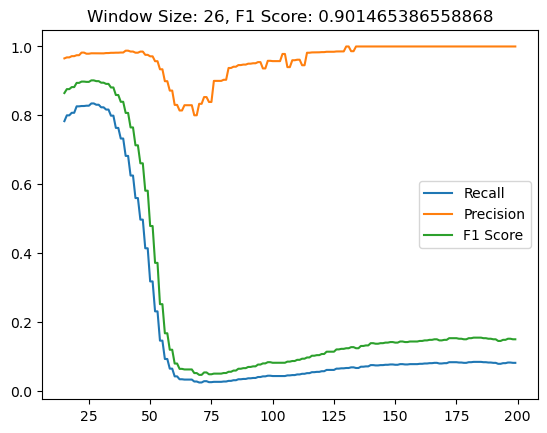

In [462]:
plt.title(f"Window Size: {15+f1.index(max(f1))}, F1 Score: {max(f1)}")
x = [15+i for i in range(len(r))]
plt.plot(x, r, label="Recall")
plt.plot(x, p, label="Precision")
plt.plot(x, f1, label="F1 Score")
plt.legend()
plt.show()

In [466]:
timestamps = len(temp)
window_size = 26
medians = np.zeros(window_size // 2).tolist()
standard_dev = np.zeros(window_size // 2).tolist()
for i in range(timestamps-window_size // 2):
    window = temp[i:i+window_size]
    window_median = np.median(window)
    standard_dev.append(np.std(np.array(window)))
    medians.append(window_median)
np.array(standard_dev)

array([0.        , 0.        , 0.        , ..., 1.72909565, 1.66625107,
       1.54452292])

In [467]:
anomalies, lb, ub = [], np.zeros(window_size // 2).tolist(), np.zeros(window_size // 2).tolist()
for i in range(window_size//2, timestamps - window_size // 2):
    threshold_1 = medians[i] + 3 * standard_dev[i]
    threshold_2 = medians[i] - 3 * standard_dev[i]
    if temp[i] > threshold_1 or temp[i] < threshold_2:
        anomalies.append(i)
    lb.append(threshold_2)
    ub.append(threshold_1)
np.array(anomalies)[:5]

array([234, 275, 381, 505, 577])

In [471]:
print(f"Accuractely Detected Anomalies out of {len(anomaly_timestamps)}: {np.sum(np.isin(anomaly_timestamps, anomalies))}")
print(f"False Alarms out of {len(normal_timestamps)}: {np.sum(np.isin(normal_timestamps, anomalies))}")

Accuractely Detected Anomalies out of 1069: 892
False Alarms out of 98931: 18


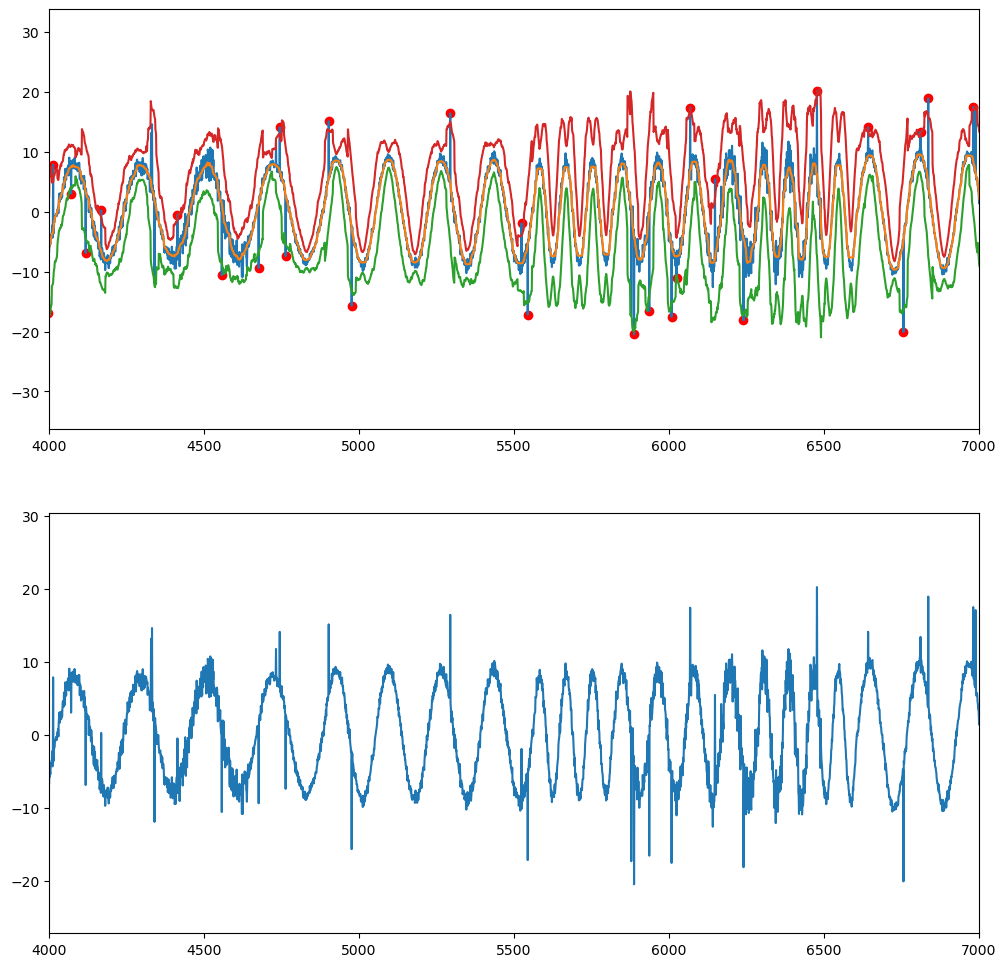

In [485]:
i = 4
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(temp)
plt.plot(medians)
plt.plot(lb)
plt.plot(ub)
plt.scatter(anomalies, temp[anomalies], color='red')
plt.xlim([i*1000, i*1000 + 3000])
plt.subplot(212)
plt.plot(test_X)
plt.xlim([i*1000, i*1000 + 3000])
plt.show()

In [492]:
import rrcf

In [637]:
data = DataCreation(500, 500000)
f_x = data.create_df(100)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X

In [638]:
test_X = data.faulty_data(test_X, 14000)
train_X = train_X.reshape(train_X.shape[0] * train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], 1)

In [639]:
n = temp.shape[0]
d = temp.shape[1]

In [629]:
forest = []
num_trees = 100
tree_size = 500
sample_size_range = (n // tree_size, tree_size)

while len(forest) < num_trees:
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    trees = [rrcf.RCTree(train_X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

In [630]:
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

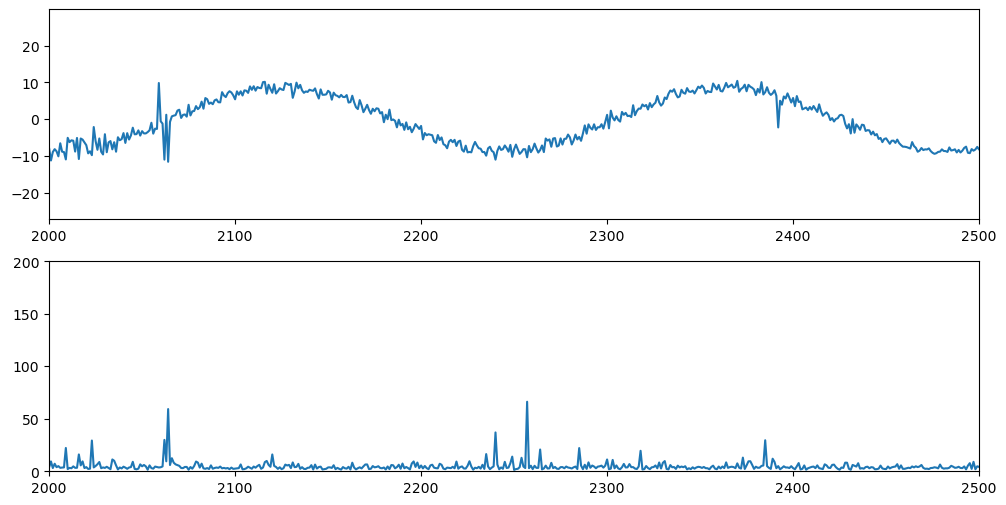

In [634]:
i = 2
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(temp)
plt.xlim([i*1000, i*1000 + 500])
plt.subplot(212)
plt.plot(avg_codisp)
plt.xlim([i*1000, i*1000 + 500])
plt.ylim([0, 200])
plt.show()

In [668]:
def RRCT(data):
    arr = np.array([])
    codisp = [0, 0]
    for i in range(2):
        shingle = np.array([data[i], data[i+1], data[i+2], data[i+3]]).reshape(1, -1)
        arr = np.append(arr, shingle)
    arr = arr.reshape(2, 4)
    tree = rrcf.RCTree(arr)
    for i in range(5, len(temp)):
        shingle = np.array([data[i-3], data[i-2], data[i-1], data[i]]).reshape(1, -1)
        tree.insert_point(shingle, index=i-3)
        codisp.append(tree.codisp(i-3))
    return tree, codisp

In [ ]:
forest = []
for i in range(100):
    tree, codisp = RRCT(test_X)
    forest.extend([tree])
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [677]:
arr = np.array([])
for i in range(2):
    shingle = np.array([test_X[i], test_X[i+1], test_X[i+2], test_X[i+3]]).reshape(1, -1)
    arr = np.append(arr, shingle)
arr = arr.reshape(2, 4)
tree = rrcf.RCTree(arr)

In [656]:
codisp = [0, 0]
for i in range(5, len(temp)):
    shingle = np.array([test_X[i-3], test_X[i-2], test_X[i-1], test_X[i]]).reshape(1, -1)
    tree.insert_point(shingle, index=i-3)
    codisp.append(tree.codisp(i-3))

In [662]:
len(codisp)

99997

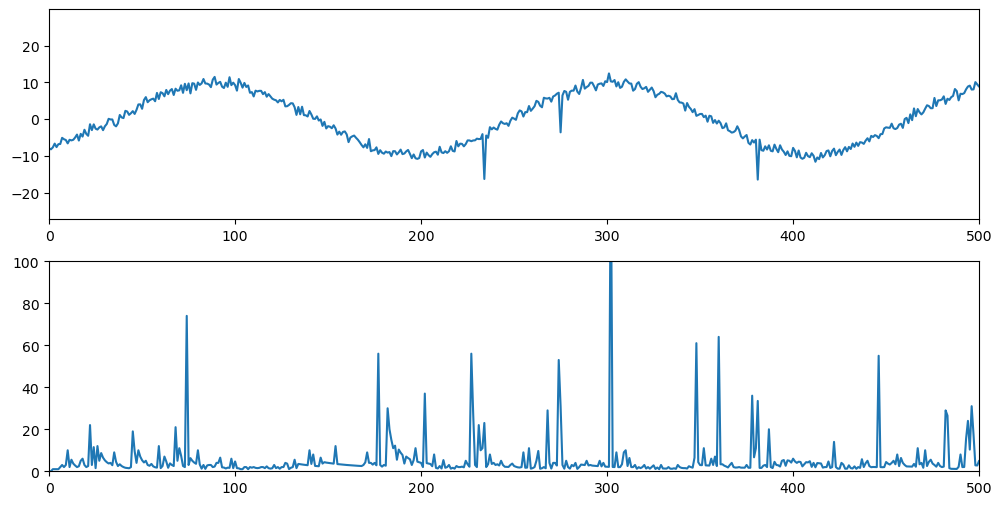

In [660]:
i = 0
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(temp)
plt.xlim([i*1000, i*1000 + 500])
plt.subplot(212)
plt.plot(codisp)
plt.xlim([i*1000, i*1000 + 500])
plt.ylim([0, 100])
plt.show()